array([[<Axes: xlabel='SIFT_score', ylabel='SIFT_score'>,
        <Axes: xlabel='am_pathogenicity', ylabel='SIFT_score'>,
        <Axes: xlabel='scr', ylabel='SIFT_score'>,
        <Axes: xlabel='pph2_prob', ylabel='SIFT_score'>],
       [<Axes: xlabel='SIFT_score', ylabel='am_pathogenicity'>,
        <Axes: xlabel='am_pathogenicity', ylabel='am_pathogenicity'>,
        <Axes: xlabel='scr', ylabel='am_pathogenicity'>,
        <Axes: xlabel='pph2_prob', ylabel='am_pathogenicity'>],
       [<Axes: xlabel='SIFT_score', ylabel='scr'>,
        <Axes: xlabel='am_pathogenicity', ylabel='scr'>,
        <Axes: xlabel='scr', ylabel='scr'>,
        <Axes: xlabel='pph2_prob', ylabel='scr'>],
       [<Axes: xlabel='SIFT_score', ylabel='pph2_prob'>,
        <Axes: xlabel='am_pathogenicity', ylabel='pph2_prob'>,
        <Axes: xlabel='scr', ylabel='pph2_prob'>,
        <Axes: xlabel='pph2_prob', ylabel='pph2_prob'>]], dtype=object)

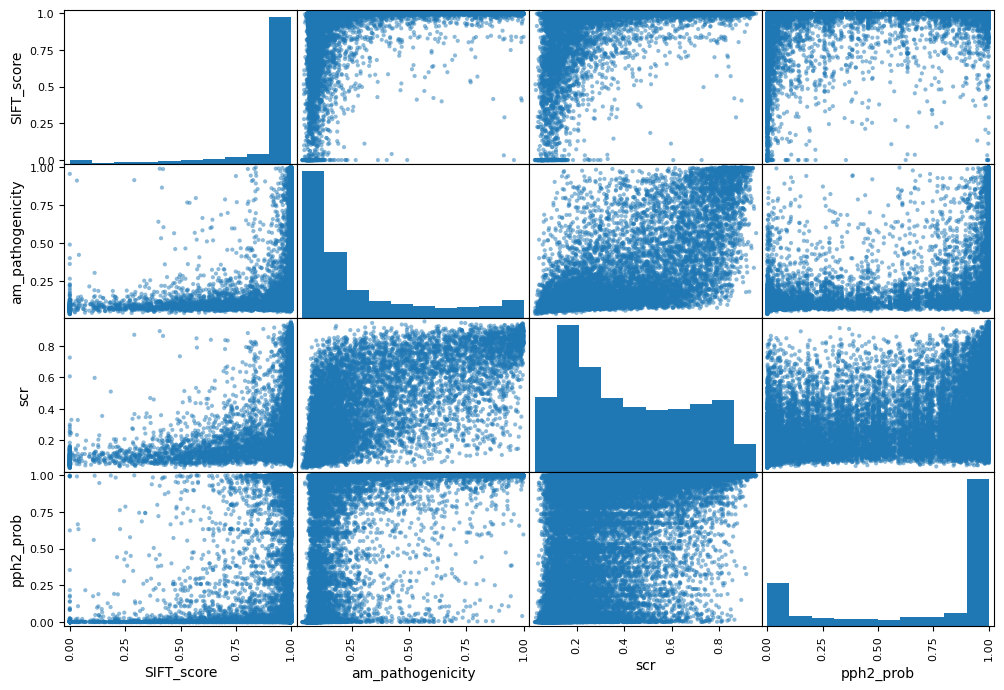

In [141]:
# using Dez_2023 Environment

import pandas as pd
import numpy as np
d = pd.read_excel("/Users/creator/Documents/Research/Bioinformatics/Idea/dataset.xlsx")
data = ["SIFT_score", "am_pathogenicity", "scr", "pph2_prob"]
from pandas.plotting import scatter_matrix
scatter_matrix(d[data], figsize=(12, 8))

In [61]:
data = ["SIFT_score", "am_pathogenicity", "scr", "pph2_prob", "group"]

# drop instances with nan
df = d.dropna(subset=data)

# look at columns
print(df["group"].value_counts())
print(df[data].describe())

# look at shape
print(df.shape[0])  # n rows, header excluded
print(df.shape[1])  # n columns

group
down    21
up       5
none     4
Name: count, dtype: int64
       SIFT_score  am_pathogenicity        scr  pph2_prob
count   30.000000         30.000000  30.000000  30.000000
mean     0.977500          0.593683   0.650978   0.896833
std      0.070809          0.356012   0.246393   0.237997
min      0.619000          0.064200   0.134030   0.000000
25%      0.989750          0.200700   0.499669   0.976250
50%      0.997000          0.681250   0.693472   0.999000
75%      0.999750          0.936750   0.866929   1.000000
max      1.000000          0.999200   0.916265   1.000000
30
16


am_pathogenicity    1.000000
scr                 0.728142
pph2_prob           0.551850
SIFT_score          0.392042
Name: am_pathogenicity, dtype: float64

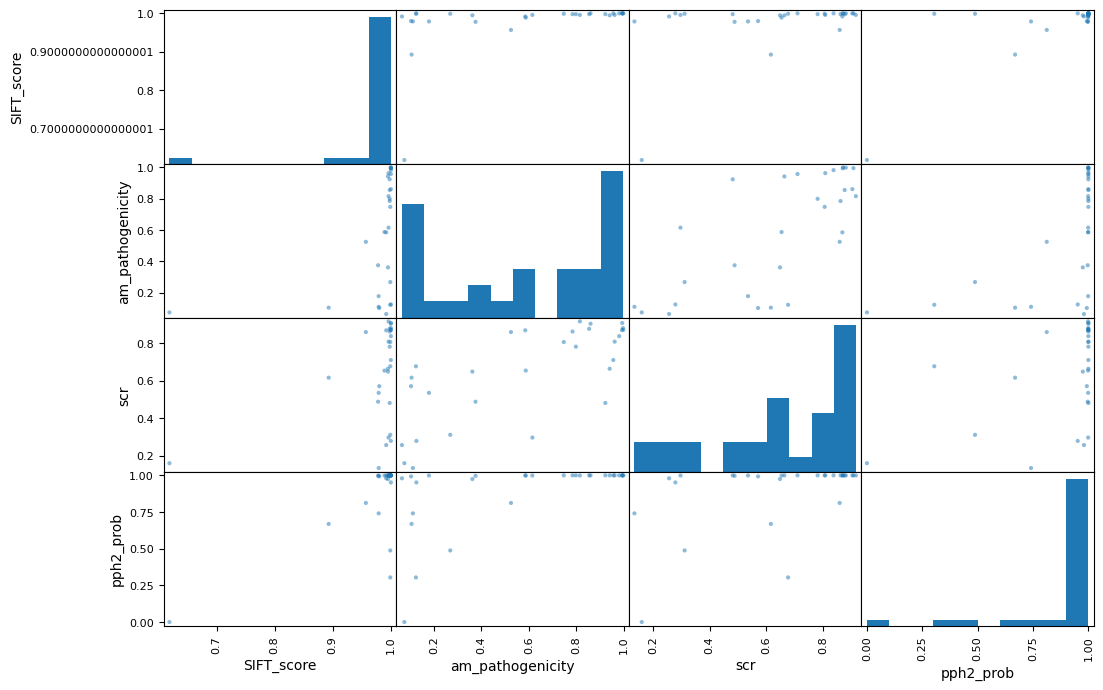

In [139]:


import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# histogram of the respective scores & group
#df[data].hist(bins=50, figsize=(20,15))
#df["group"].hist()

# plot all scores against each other
scatter_matrix(df[data], figsize=(12, 8))

# further evaluate strength of the linear relationship between different VEPs
data_values = ["SIFT_score", "am_pathogenicity", "scr", "pph2_prob"]
corr_matrix = df[data_values].corr()
corr_matrix["am_pathogenicity"].sort_values(ascending=False)
#plt.show()

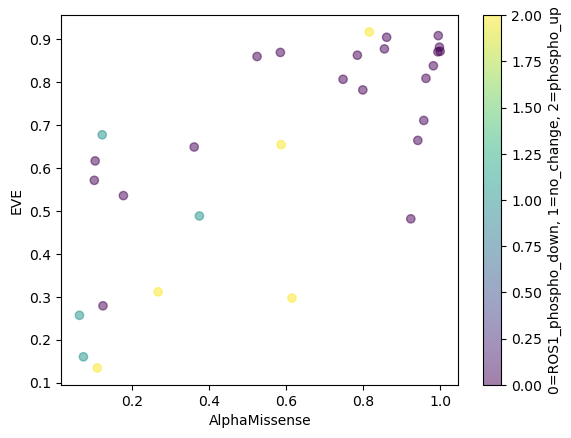

In [183]:
plt.scatter(df['am_pathogenicity'], df['scr'], c=df['group_encoded'], alpha=0.5, cmap='viridis')
plt.xlabel('AlphaMissense')
plt.ylabel('EVE')
plt.colorbar(label="0=ROS1_phospho_down, 1=no_change, 2=phospho_up")
plt.show()

# FAZIT
-polyphen & sift haben keine klaren/linearen Korrelation und verschlechtern die Vorhersagen, daher rausnehmen
-gute vorhersage von effekt vs kein effekt möglich: siehe plot, mutationen mit phospho down haben bei eve & am erhöhten score, mutationen mit phospho_no_change haben niedrigeren score 
    ABER: phospho-up nicht in einer klaren ecke, sondern in einer linearen gerade, aka nicht eindeutig zurordbar
-ALSO: neue features müssen gefunden werden, consensus strategie wahrscheinlich nicht erfolgreich, bei der down, none und up predictions
    ABER: vielleicht nochmal auf großem MAVE BRCA1 datensatz ausprobieren

In [176]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit


# Assuming df is your DataFrame
feature_columns = ["am_pathogenicity", "scr"]

custom_mapping = {'down': 0, 'none': 1, 'up': 2}
df['group_encoded'] = df['group'].map(custom_mapping)

# simple Train-test split
#X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df['group_encoded'], test_size=0.2, random_state=42)

# stratfied train-test split (sampling)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.reset_index(drop=True, inplace=True)

for train_index, test_index in split.split(df, df["group_encoded"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# dividing features an labels in train & test
X_train = strat_train_set[feature_columns].copy()  # X features (exclude the target column)
y_train = strat_train_set["group_encoded"].copy()  # Y labels (target column)

X_test = strat_test_set[feature_columns].copy()  # X features for test set
y_test = strat_test_set["group_encoded"].copy()

# Random Forest classifier initialization and training
rf_classifier = RandomForestClassifier(n_estimators=42, random_state=42)
print("ytest", y_test, "pred", predictions)
rf_classifier.fit(X_train, y_train)


# Example prediction
predictions = rf_classifier.predict(X_test)


# Example evaluation
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, predictions))



ytest 12    0
20    2
23    0
8     0
17    0
27    1
Name: group_encoded, dtype: int64 pred [0 0 0 0 0 1]
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.60      0.67      0.63         6
weighted avg       0.70      0.83      0.76         6



/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit


# Assuming df is your DataFrame
feature_columns = ["am_pathogenicity", "scr"]

custom_mapping = {'down': 0, 'none': 1, 'up': 2}
df['group_encoded'] = df['group'].map(custom_mapping)

# simple Train-test split
#X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df['group_encoded'], test_size=0.2, random_state=42)

# stratfied train-test split (sampling)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.reset_index(drop=True, inplace=True)

for train_index, test_index in split.split(df, df["group_encoded"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# dividing features an labels in train & test
X_train = strat_train_set.drop("group_encoded", axis=1)  # X features (exclude the target column)
print(strat_test_set)
y_train = strat_train_set[feature_columns].copy()  # Y labels (target column)

X_test = strat_test_set.drop("group_encoded", axis=1)  # X features for test set
y_test = strat_test_set[feature_columns].copy()

# Random Forest classifier initialization and training
rf_classifier = RandomForestClassifier(n_estimators=15, random_state=42)
rf_classifier.fit(X_train, y_train)


# Example prediction
predictions = rf_classifier.predict(X_test)
print(y_test, "\n", "predictions: ", predictions)

# Example evaluation
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, predictions))



    Unnamed: 0  Position WT_Allele mutant  SIFT_score mutation  \
12       39000      2053         L      F       0.979   L2053F   
20       40130      2113         D      N       0.989   D2113N   
23       40391      2126         R      W       1.000   R2126W   
8        38576      2031         G      E       0.995   G2031E   
17       39684      2089         V      M       0.893   V2089M   
27       41914      2207         T      A       0.992   T2207A   

    am_pathogenicity       scr Mutation    Average group   score   pos aa1  \
12            0.1782  0.535232   L2053F   0.342069  down  0.1782  2053   L   
20            0.5870  0.653827   D2113N  30.527292    up  0.5870  2113   D   
23            0.9567  0.710169   R2126W   0.056010  down  0.9567  2126   R   
8             0.9413  0.663715   G2031E   0.043275  down  0.9413  2031   G   
17            0.1049  0.615988   V2089M   0.699780  down  0.1049  2089   V   
27            0.0642  0.256502   T2207A   1.440419  none  0.0642  220

/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

ValueError: could not convert string to float: 'D'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit


# Assuming df is your DataFrame
feature_columns = ["am_pathogenicity", "scr"]

custom_mapping = {'down': 0, 'none': 1, 'up': 2}
df['group_encoded'] = df['group'].map(custom_mapping)

# simple Train-test split
#X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df['group_encoded'], test_size=0.2, random_state=42)

# stratfied train-test split (sampling)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.reset_index(drop=True, inplace=True)

for train_index, test_index in split.split(df, df["group_encoded"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# dividing features an labels in train & test
X_train = strat_train_set.drop("group_encoded", axis=1)  # X features (exclude the target column)
print(strat_test_set)
y_train = strat_train_set[feature_columns].copy()  # Y labels (target column)

X_test = strat_test_set.drop("group_encoded", axis=1)  # X features for test set
y_test = strat_test_set[feature_columns].copy()

# Random Forest classifier initialization and training
rf_classifier = RandomForestClassifier(n_estimators=15, random_state=42)
rf_classifier.fit(X_train, y_train)


# Example prediction
predictions = rf_classifier.predict(X_test)
print(y_test, "\n", "predictions: ", predictions)

# Example evaluation
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, predictions))



    Unnamed: 0  Position WT_Allele mutant  SIFT_score mutation  \
12       39000      2053         L      F       0.979   L2053F   
20       40130      2113         D      N       0.989   D2113N   
23       40391      2126         R      W       1.000   R2126W   
8        38576      2031         G      E       0.995   G2031E   
17       39684      2089         V      M       0.893   V2089M   
27       41914      2207         T      A       0.992   T2207A   

    am_pathogenicity       scr Mutation    Average group   score   pos aa1  \
12            0.1782  0.535232   L2053F   0.342069  down  0.1782  2053   L   
20            0.5870  0.653827   D2113N  30.527292    up  0.5870  2113   D   
23            0.9567  0.710169   R2126W   0.056010  down  0.9567  2126   R   
8             0.9413  0.663715   G2031E   0.043275  down  0.9413  2031   G   
17            0.1049  0.615988   V2089M   0.699780  down  0.1049  2089   V   
27            0.0642  0.256502   T2207A   1.440419  none  0.0642  220

/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

ValueError: could not convert string to float: 'D'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit


# Assuming df is your DataFrame
feature_columns = ["am_pathogenicity", "scr"]

custom_mapping = {'down': 0, 'none': 1, 'up': 2}
df['group_encoded'] = df['group'].map(custom_mapping)

# simple Train-test split
#X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df['group_encoded'], test_size=0.2, random_state=42)

# stratfied train-test split (sampling)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.reset_index(drop=True, inplace=True)

for train_index, test_index in split.split(df, df["group_encoded"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# dividing features an labels in train & test
X_train = strat_train_set.drop("group_encoded", axis=1)  # X features (exclude the target column)
print(strat_test_set)
y_train = strat_train_set[feature_columns].copy()  # Y labels (target column)

X_test = strat_test_set.drop("group_encoded", axis=1)  # X features for test set
y_test = strat_test_set[feature_columns].copy()

# Random Forest classifier initialization and training
rf_classifier = RandomForestClassifier(n_estimators=15, random_state=42)
rf_classifier.fit(X_train, y_train)


# Example prediction
predictions = rf_classifier.predict(X_test)
print(y_test, "\n", "predictions: ", predictions)

# Example evaluation
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, predictions))



    Unnamed: 0  Position WT_Allele mutant  SIFT_score mutation  \
12       39000      2053         L      F       0.979   L2053F   
20       40130      2113         D      N       0.989   D2113N   
23       40391      2126         R      W       1.000   R2126W   
8        38576      2031         G      E       0.995   G2031E   
17       39684      2089         V      M       0.893   V2089M   
27       41914      2207         T      A       0.992   T2207A   

    am_pathogenicity       scr Mutation    Average group   score   pos aa1  \
12            0.1782  0.535232   L2053F   0.342069  down  0.1782  2053   L   
20            0.5870  0.653827   D2113N  30.527292    up  0.5870  2113   D   
23            0.9567  0.710169   R2126W   0.056010  down  0.9567  2126   R   
8             0.9413  0.663715   G2031E   0.043275  down  0.9413  2031   G   
17            0.1049  0.615988   V2089M   0.699780  down  0.1049  2089   V   
27            0.0642  0.256502   T2207A   1.440419  none  0.0642  220

/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

ValueError: could not convert string to float: 'D'

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import numpy as np
myseed = 42
np.random.seed(myseed)
torch.manual_seed(myseed)


# Assuming df is your DataFrame
feature_columns = ["SIFT_score", "am_pathogenicity", "scr", "pph2_prob"]
label_columns = ["group"]

# Import necessary libraries
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 1. encode "down" etc. as 0, 1 and 2
label_encoder = LabelEncoder()
df['group_encoded'] = label_encoder.fit_transform(df['group'])
print(label_encoder.classes_)

#2. make one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
labels_onehot = onehot_encoder.fit_transform(df['group_encoded'].values.reshape(-1, 1))

# Separate features and labels
features = torch.tensor(df[feature_columns].values, dtype=torch.float32)
labels = torch.tensor(labels_onehot, dtype=torch.float32)

# Shuffle the indices
indices = list(range(len(features)))
np.random.shuffle(indices)

# Use the shuffled indices to create training and testing sets
train_size = int(0.8 * len(features))
train_indices, test_indices = indices[:train_size], indices[train_size:]

X_train, X_test = features[train_indices], features[test_indices]
y_train, y_test = labels[train_indices], labels[test_indices]

# Define the neural network model
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleClassifier(input_size=4, hidden_size=2, output_size=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.2)

# Training the model
num_epochs = 70
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    print("loss", loss)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluation
with torch.no_grad():
    model.eval()
    print("pred", model(X_test))
    predictions = model(X_test).argmax(dim=1)
    print("predictions", predictions)
    print("y_test", y_test)
    accuracy = (predictions == y_test.argmax(dim=1)).float().mean().item()
    print(f"Accuracy: {accuracy}")


['down' 'none' 'up']
loss tensor(0.8590, grad_fn=<DivBackward1>)
loss tensor(0.7931, grad_fn=<DivBackward1>)
loss tensor(0.7855, grad_fn=<DivBackward1>)
loss tensor(0.7413, grad_fn=<DivBackward1>)
loss tensor(0.7276, grad_fn=<DivBackward1>)
loss tensor(0.7129, grad_fn=<DivBackward1>)
loss tensor(0.6744, grad_fn=<DivBackward1>)
loss tensor(0.6272, grad_fn=<DivBackward1>)
loss tensor(0.5924, grad_fn=<DivBackward1>)
loss tensor(0.5685, grad_fn=<DivBackward1>)
loss tensor(0.5468, grad_fn=<DivBackward1>)
loss tensor(0.5335, grad_fn=<DivBackward1>)
loss tensor(0.5230, grad_fn=<DivBackward1>)
loss tensor(0.5214, grad_fn=<DivBackward1>)
loss tensor(0.5142, grad_fn=<DivBackward1>)
loss tensor(0.5063, grad_fn=<DivBackward1>)
loss tensor(0.5044, grad_fn=<DivBackward1>)
loss tensor(0.5023, grad_fn=<DivBackward1>)
loss tensor(0.4968, grad_fn=<DivBackward1>)
loss tensor(0.4914, grad_fn=<DivBackward1>)
loss tensor(0.4888, grad_fn=<DivBackward1>)
loss tensor(0.4860, grad_fn=<DivBackward1>)
loss tensor

/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [193]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

myseed = 42
np.random.seed(myseed)
torch.manual_seed(myseed)


# Assuming df is your DataFrame
feature_columns = ["SIFT_score", "am_pathogenicity"]
label_columns = ["group"]

# Import necessary libraries
from sklearn.preprocessing import OneHotEncoder

# 1. encode "down" etc. as 0, 1 and 2
label_encoder = LabelEncoder()
df['group_encoded'] = label_encoder.fit_transform(df['group'])
#print(label_encoder.classes_)

#2. make one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
labels_onehot = onehot_encoder.fit_transform(df['group_encoded'].values.reshape(-1, 1))

# Separate features and labels
features = torch.tensor(df[feature_columns].values, dtype=torch.float32)
labels = torch.tensor(labels_onehot, dtype=torch.float32)

# Define the neural network model
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


# Initialize K-Fold
num_folds = 3  # You can adjust the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=myseed)

# Training the model with cross-validation
for fold, (train_indices, test_indices) in enumerate(kf.split(features)):
    X_train, X_test = features[train_indices], features[test_indices]
    y_train, y_test = labels[train_indices], labels[test_indices]

    # Initialize the model
    model = SimpleClassifier(input_size=2, hidden_size=3, output_size=3)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.05)

    # Training the model
    num_epochs = 5
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation
    with torch.no_grad():
        model.eval()
        predictions = model(X_test).argmax(dim=1)
        accuracy = (predictions == y_test.argmax(dim=1)).float().mean().item()
        print(f"Fold {fold + 1}, Accuracy: {accuracy}")


Fold 1, Accuracy: 0.6000000238418579
Fold 2, Accuracy: 0.8999999761581421
Fold 3, Accuracy: 0.6000000238418579


/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/creator/anaconda3/envs/Dez_2023/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:

# Shuffle the indices
indices = list(range(len(features)))
np.random.shuffle(indices)

# Use the shuffled indices to create training and testing sets
train_size = int(0.8 * len(features))
train_indices, test_indices = indices[:train_size], indices[train_size:]

X_train, X_test = features[train_indices], features[test_indices]
y_train, y_test = labels[train_indices], labels[test_indices]


synaptic efficacies: [0.48786431 0.78734086 0.58497408 0.48078973 0.26257864 0.6626094
 0.28765698 1.1051914  1.23459297 0.19019473] 

Pre-training accuracy: 50.0
Current Epoch: 0. Accuracy: 50.0. Loss: 0.26169420324780335
Current Epoch: 1. Accuracy: 50.0. Loss: 0.25162035843479846
Current Epoch: 2. Accuracy: 50.0. Loss: 0.24154652363950602
Current Epoch: 3. Accuracy: 50.0. Loss: 0.23147269911031598
Current Epoch: 4. Accuracy: 50.0. Loss: 0.22139888510389993
Current Epoch: 5. Accuracy: 50.0. Loss: 0.21132508188555899
Current Epoch: 6. Accuracy: 50.0. Loss: 0.20125128972958994
Current Epoch: 7. Accuracy: 50.0. Loss: 0.191177508919671
Current Epoch: 8. Accuracy: 50.0. Loss: 0.18110373974926408
Current Epoch: 9. Accuracy: 50.0. Loss: 0.17102998252204227
Current Epoch: 10. Accuracy: 50.0. Loss: 0.1609562375523359
Current Epoch: 11. Accuracy: 50.0. Loss: 0.1508825051656073
Current Epoch: 12. Accuracy: 50.0. Loss: 0.14080878569894373
Current Epoch: 13. Accuracy: 50.0. Loss: 0.130735079501586

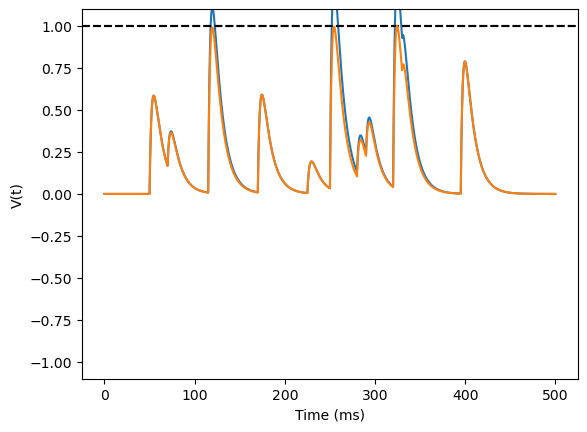

In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from numba import jit


class Tempotron:
    """
    A class representing a tempotron, as described in
    Gutig & Sompolinsky (2006).
    The (subthreshold) membrane voltage of the tempotron
    is a weighted sum from all incoming spikes and the
    resting potential of the neuron. The contribution of
    each spike decays exponentiall with time, the speed of
    this decay is determined by two parameters tau and tau_s,
    denoting the decay time constants of membrane integration
    and synaptic currents, respectively.
    """
    def __init__(self, V_rest, tau, tau_s, synaptic_efficacies, t_max, threshold=1.0, jit_mode=False, verbose=False, accuracy=False):
        # set parameters as attributes
        self.V_rest = V_rest
        self.tau = float(tau)
        self.tau_s = float(tau_s)
        self.log_tts = np.log(self.tau/self.tau_s)
        self.threshold = threshold
        self.efficacies = synaptic_efficacies
        self.t_spi = 10     # spike integration time, compute this with formula
        self.jit_mode = jit_mode
        self.verbose = verbose
        self.t_max = t_max

        # compute normalisation factor V_0
        self.V_norm = self.compute_norm_factor(tau, tau_s)
        

    def compute_norm_factor(self, tau, tau_s):
        """
        Compute and return the normalisation factor:

        V_0 = (tau * tau_s * log(tau/tau_s)) / (tau - tau_s)

        That normalises the function:
                
        K(t-t_i) = V_0 (exp(-(t-t_i)/tau) - exp(-(t-t_i)/tau_s)

        Such that it amplitude is 1 and the unitary PSP
        amplitudes are given by the synaptic efficacies.
        """
        tmax = (tau * tau_s * np.log(tau/tau_s)) / (tau - tau_s)
        v_max = self.K(1, tmax, 0)
        V_0 = 1/v_max
        return V_0

    def K(self, V_0, t, t_i):
        """
        Compute the function

        K(t-t_i) = V_0 (exp(-(t-t_i)/tau) - exp(-(t-t_i)/tau_s)
        """
        if self.jit_mode:
            return self.K_jit(V_0, t, t_i, self.tau, self.tau_s)
        if t < t_i:
            value = 0
        else:
            value = V_0 * (np.exp(-(t-t_i)/self.tau) - np.exp(-(t-t_i)/self.tau_s))
        return value

    def compute_membrane_potential(self, t, spike_times):
        """
        Compute the membrane potential of the neuron given
        by the function:

        V(t) = sum_i w_i sum_{t_i} K(t-t_i) + V_rest

        Where w_i denote the synaptic efficacies and t_i denote
        ith afferent.
        
        :param spike_times: an array with at position i the spike times of
                            the ith afferent
        :type spike_times: numpy.ndarray
        """
        # create an array with the contributions of the
        # spikes for each synaps
        spike_contribs = self.compute_spike_contributions(t, spike_times)

        # multiply with the synaptic efficacies
        total_incoming = spike_contribs * self.efficacies

        # add sum and add V_rest to get membrane potential
        V = total_incoming.sum() + self.V_rest
        
        return V

    def compute_derivative(self, t, spike_times):
        """
        Compute the derivative of the membrane potential
        of the neuron at time t.
        This derivative is given by:

        V'(t) = V_0 sum_i w_i sum_{t_n} (exp(-(t-t_n)/tau_s)/tau_s - exp(-(t-t_n)/tau)/tau)

        for t_n < t
        """
        # sort spikes in chronological order
        spikes_chron = [(time, synapse) for synapse in range(len(spike_times)) for time in spike_times[synapse]]
        spikes_chron.sort()

        # Make a list of spike times and their corresponding weights
        spikes = [(s[0], self.efficacies[s[1]]) for s in spikes_chron]

        # At time t we want to incorporate all the spikes for which
        # t_spike < t
        sum_tau = np.array([spike[1]*np.exp(spike[0]/self.tau) for spike in spikes if spike[0] <= t], dtype=object).sum()
        sum_tau_s = np.array([spike[1]*np.exp(spike[0]/self.tau_s) for spike in spikes if spike[0] <= t], dtype=object).sum()

        factor_tau = np.exp(-t/self.tau)/self.tau
        factor_tau_s = np.exp(-t/self.tau_s)/self.tau_s

        deriv = self.V_norm * (factor_tau_s*sum_tau_s - factor_tau*sum_tau)
        
        return deriv

    def compute_spike_contributions(self, t, spike_times):
        """
        Compute the decayed contribution of the incoming spikes.
        """

        # nr of synapses
        N_synapse = len(spike_times)
        # loop over spike times to compute the contributions
        # of individual spikes
        spike_contribs = np.zeros(N_synapse)
        for neuron_pos in range(N_synapse):
            for spike_time in spike_times[neuron_pos]:
                # print self.K(self.V_rest, t, spike_time)
                spike_contribs[neuron_pos] += self.K(self.V_norm, t, spike_time)
        
        return spike_contribs

    def train(self, io_pairs, steps, learning_rate):
        """
        Train the tempotron on the given input-output pairs,
        applying gradient decscend to adapt the weights.

        :param steps: the maximum number of training steps
        :param io_pairs: a list with tuples of spike times and the
                         desired response on them
        :param learning_rate: the learning rate of the gradient descend
        """
        # Run until maximum number of steps is reached or
        # no weight updates occur anymore

        accuracy_list = []
        loss_list = []
        n_pairs = len(io_pairs)
        for i in range(steps):
            # go through io-pairs in random orde
            n_correct = 0
            loss = 0
            for spike_times, target in np.random.permutation(io_pairs):
                out = self.adapt_weights(spike_times, target, learning_rate)
                n_correct += int(out == 0)  # Correct output is 0
                loss += out
            accuracy = (n_correct / n_pairs) * 100
            accuracy_list.append(accuracy)
            loss_list.append(loss)
            if self.verbose:
                print(f"Current Epoch: {i}. Accuracy: {accuracy}. Loss: {loss}")
        return accuracy_list, loss_list

    def get_membrane_potentials(self, t_start, t_end, spike_times, interval=0.1):
        """
        Get a list of membrane potentials from t_start to t_end
        as a result of the inputted spike times.
        """
        # create vectorised version of membrane potential function
        potential_vect = np.vectorize(self.compute_membrane_potential)
        # exclude spike times from being vectorised
        potential_vect.excluded.add(1)

        # compute membrane potentials
        t = np.arange(t_start, t_end, interval)
        membrane_potentials = potential_vect(t, spike_times)

        return t, membrane_potentials

    def get_derivatives(self, t_start, t_end, spike_times, interval=0.1):
        """
        Get a list of the derivative of the membrane potentials from
        t_start to t_end as a result of the inputted spike times.
        """
        # create a vectorised version of derivative function
        deriv_vect = np.vectorize(self.compute_derivative)
        # exclude spike times from being vectorised
        deriv_vect.excluded.add(1)

        # compute derivatives
        t = np.arange(t_start, t_end, interval)
        derivatives = deriv_vect(t, spike_times)

        return t, derivatives

    def plot_membrane_potential(self, t_start, t_end, spike_times, interval=0.1):
        """
        Plot the membrane potential between t_start and t_end as
        a result of the input spike times.
        :param t_start: start time in ms
        :param t_end: end time in ms
        :param interval: time step at which membrane potential is computed
        """
        # compute membrane_potential
        t, membrane_potentials = self.get_membrane_potentials(t_start, t_end, spike_times, interval)

        # format axes
        plt.xlabel('Time (ms)')
        plt.ylabel('V(t)')

        ymax = max(membrane_potentials.max() + 0.1, self.threshold + 0.1)
        ymin = min(membrane_potentials.min() - 0.1, -self.threshold - 0.1)
        plt.ylim(ymax=ymax, ymin=ymin)
        plt.axhline(y=self.threshold, linestyle='--', color='k')
        
        # plot membrane potential
        plot = plt.plot(t, membrane_potentials)
        # return plot
        # plt.show()

    def plot_potential_and_derivative(self, t_start, t_end, spike_times, interval=0.1):
        """
        Plot the membrane potential and the derivative of the membrane
        potential as a result of the input spikes between t_start and
        t_end.
        :param t_start: start time in ms
        :param t_end: end time in ms
        """
        # compute membrane potentials
        t, membrane_potentials = self.get_membrane_potentials(t_start, t_end, spike_times, interval)

        # compute derivatives
        t, derivatives = self.get_derivatives(t_start, t_end, spike_times, interval)

        # format axes
        plt.xlabel('Time(ms)')
        # ylabel???

        ymax = max(membrane_potentials.max() + 0.1, self.threshold + 0.1)
        ymin = min(membrane_potentials.min() - 0.1, -self.threshold - 0.1)
        plt.ylim(ymax=ymax, ymin=ymin)

        plt.axhline(y=self.threshold, linestyle='--', color='k')
        plt.axhline(y=0.0, linestyle='--', color='r')
        plt.axvline(x=16.5, color='b')

        # plot
        plt.plot(t, membrane_potentials, label='Membrane potential')
        plt.plot(t, derivatives, label='Derivative')
        plt.show()

    def compute_tmax(self, spike_times):
        """
        Compute the maximum mebrane potential of the tempotron as
        a result of the input spikes.
        The maxima of the function can be computed analytically, but as
        there are as many maxima and minima as their are number of spikes,
        we still need to sort through them to find the highest one.

        The maxima are given by:

        t = (log(tau/tau_s) + log(sum w_n exp(t_n/tau_s)) - log(sum w_n exp(t_n/tau)))*tau_s*tau/ (tau-tau_s)

        for n = 1, 2, ..., len(spike_times)

        The time at which the membrane potential is maximal is given by
        Check if the input spikes result produce the desired
        output. Return tmax. (maybe I should return something else)
        """

        # sort spikes in chronological order
        spikes_chron = [(time, synapse) for synapse in range(len(spike_times)) for time in spike_times[synapse]]
        spikes_chron.sort()

        # Make a list of spike times and their corresponding weights
        spikes = [(s[0], self.efficacies[s[1]]) for s in spikes_chron]
        times = np.array([spike[0] for spike in spikes])
        weights = np.array([spike[1] for spike in spikes])
        
        sum_tau = (weights*np.exp(times/self.tau)).cumsum()
        sum_tau_s = (weights*np.exp(times/self.tau_s)).cumsum()

        # In case of overflow, calculate tmax by simulating the membrane voltage
        if np.isnan(sum_tau).any() or np.isnan(sum_tau_s).any():
            vm = self.get_membrane_potentials(0, self.t_max, spike_times)
            return vm[0][vm[1].argmax()]

        # when an inhibitive spike is generated when the membrane potential
        # is still growing, the derivative does not exist in the maximum
        # In such cases, thus when sum_tau/sum_tau_s is negative,
        # manually set tmax to the spike time of the second spike
        div = sum_tau_s/sum_tau
        boundary_cases = div < 0
        div[boundary_cases] = 10

        tmax_list = self.tau*self.tau_s*(self.log_tts + np.log(div))/(self.tau - self.tau_s)
        tmax_list[boundary_cases] = times[boundary_cases]

        vmax_list = np.array([self.compute_membrane_potential(t, spike_times) for t in tmax_list])

        tmax = tmax_list[vmax_list.argmax()]
        # pdb.set_trace()
        return tmax

    def adapt_weights(self, spike_times, target, learning_rate):
        """
        Modify the synaptic efficacies such that the learns
        to classify the input pattern correctly.
        Whenever an error occurs, the following update is
        computed:

        dw = lambda sum_{ti} K(t_max, ti)

        The synaptic efficacies are increased by this weight
        if the tempotron did erroneously not elecit an output
        spike, and decreased if it erroneously did.
        :param spike_times: an array with lists of spike times
                            for every afferent
        :param output_spike: the classification of the input pattern
        :type output_spike: Boolean
        """

        # compute tmax
        tmax = self.compute_tmax(spike_times)
        vmax = self.compute_membrane_potential(tmax, spike_times)

        # print "vmax = ", vmax
        # print "target = ", target

        # if target output is correct, don't adapt weights
        if (vmax >= self.threshold) == target:
            # print "no weight update necessary"
            return 0

        # compute weight updates
        dw = self.dw(learning_rate, tmax, spike_times)
        # print "update =", dw

        if target is True:
            self.efficacies += dw
        else:
            self.efficacies -= dw
        
        return np.abs(vmax - self.threshold)

    def dw(self, learning_rate, tmax, spike_times):
        """
        Compute the update for synaptic efficacies wi,
        according to the following learning rule
        (implementing gradient descend dynamics):

        dwi = lambda sum_{ti} K(t_max, ti)

        where lambda is the learning rate and t_max denotes
        the time at which the postsynaptic potential V(t)
        reached its maximal value.
        """
        # compute the contributions of the individual spikes at
        # time tmax
        spike_contribs = self.compute_spike_contributions(tmax, spike_times)

        # multiply with learning rate to get updates
        update = learning_rate * spike_contribs

        return update

    def accuracy(self, io_pairs):
        """Return the percentage of accurately classified io_pairs"""
        accurate = 0
        for spike_times, target in np.random.permutation(io_pairs):
            tmax = self.compute_tmax(spike_times)
            vmax = self.compute_membrane_potential(tmax, spike_times)
            output = vmax > self.threshold
            if output == target:
                accurate += 1

        return (accurate / len(io_pairs)) * 100

    @staticmethod
    @jit(nopython=True)
    def K_jit(V_0, t, t_i, tau, tau_s):
        """
        Compute the function

        K(t-t_i) = V_0 (exp(-(t-t_i)/tau) - exp(-(t-t_i)/tau_s)
        """
        if t < t_i:
            value = 0
        else:
            value = V_0 * (np.exp(-(t-t_i)/tau) - np.exp(-(t-t_i)/tau_s))
        return value

    
if __name__ == '__main__':
    np.random.seed(0)
    efficacies = 1.8 * np.random.random(10) - 0.50
    print('synaptic efficacies:', efficacies, '\n')

    tempotron = Tempotron(0, 10, 2.5, efficacies, 2000, jit_mode=False, verbose=True)
    # tempotron_jit = Tempotron(0, 10, 2.5, efficacies, jit_mode=True)
    

    # efficacies = np.array([0.8, 0.8, 0.8, 0.8, 0.8])
    spike_times1 = np.array([[70, 200, 400], [], [400, 420], [], [110], [230], [240, 260, 340], [380], [300], [105]], dtype=object)
    spike_times2 = np.array([[], [395], [50, 170], [], [70, 280], [], [290], [115], [250, 320], [225, 330]], dtype=object)
    spike_times = np.array([[0, 10], [], [3], [], [], [], [], [], [], []], dtype=object)
    print("Pre-training accuracy: " + 
          str(tempotron.accuracy(np.array([(spike_times1, True), (spike_times2, False)], dtype=object))))
    # tempotron.plot_membrane_potential(0, 500, spike_times1)
    tempotron.plot_membrane_potential(0, 500, spike_times2)
    #plt.show()
    tempotron.train(np.array([(spike_times1, True), (spike_times2, False)], dtype=object), 100, learning_rate=10e-3)
    print("Post-training accuracy: " + 
          str(tempotron.accuracy(np.array([(spike_times1, True), (spike_times2, False)], dtype=object))))
    # tempotron.plot_membrane_potential(0, 500, spike_times1)
    tempotron.plot_membrane_potential(0, 500, spike_times2)
    plt.show()